In [2]:
import sys
import os
from glob import glob
import numpy as np

import torch
from torch import nn
import torchvision.transforms.functional as TF
from sklearn.metrics import f1_score
import cv2

import matplotlib.pyplot as plt 

from PIL import Image

#from src.utils import *
from src_notebooks.output_scaling_methods import *
from src_notebooks.pytorch_utils import ImageDataset
from src_notebooks.models import UNet, ResNet18UNet
#from src.dataset_extension import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Experiments on the output rescaling process

Some of our models (unet and ResNetUnet) use and input and output size of 384x384 pixels. Since our final predictions should be 400x400 pixels large, we devised 3 methods to compute the final output:

1. Simple Resizing.
   The Image gets downsampled before running through the model and the result is upscaled again.

2. Stitching.
   The Image is first split into 4 smaller images of correct input size covering all pixels of the original input. Then each of them gets run through the model and the result is "stitched" together by taking a part of each image to combine it to the original size. (The seam is chosen to be going through the center, i.e. each images provides one quarter of the final prediction)

3. Blending.
   The images are split as in the stitching part. But the recombination is done by averaging all four sub-images. Where there is only one ore two images contributing to an area the weights are chosen accordingly.


It results that the best method depends on the model. Some perform best with resizing, other better with blending or stitching. In the end, the differences are small

### Comparisions using the model below:

In [3]:
# Load Model. Choose your own to see which method works best. Different models had different methods to work better for them but overall differences are small as seen in this example
model_name = "resnet18_gmap20k.pt"
net = ResNet18UNet().to(device)

if(os.path.exists(os.path.join("backup_models",model_name))):
    savedModel = torch.load(os.path.join("backup_models",model_name))
    net.load_state_dict(savedModel["model_state_dict"])
else:
    print("couldn't find a torch model with this name in the specified path")

couldn't find a torch model with this name in the specified path


Perform the different output creation strategies on the training set and compare it to the groundtruths

In [38]:
# Load The images to test for, Here we use the provided training images
training_images_fns = glob(os.path.join("training", "images", "*.png"))
gt_fns = glob(os.path.join("training", "groundtruth","*.png"))
training_images = np.stack([np.moveaxis(TF.to_tensor(Image.open(x).convert("RGB")).detach().numpy(),0,2) for x in training_images_fns],axis=0)
training_gt = np.concatenate([ TF.to_tensor(Image.open(x)).detach().numpy() for x in gt_fns],axis=0)

# Compute the predictions through the different methods
resized = predict_by_resizing(net,resize_shape=(384,384))
part_predictions = predict_by_parts(net, input_size=384)
stitched = stitch_predictions(part_predictions,16*12) # seam at center
blended = blend_predictions(part_predictions)

In [39]:
# Compute average, min and max score over the given groundtruths
print("method: (avg_score, min_score, max_score, min_index, max_index)")
print("resized: ", patch_accuracy_metrics(training_gt, resized))
print("stitched: ", patch_accuracy_metrics(training_gt, stitched))
print("blended: ", patch_accuracy_metrics(training_gt, blended))

method: (avg_score, min_score, max_score, min_index, max_index)
resized:  (0.9346999999999999, 0.8448, 0.9856, 105, 53)
stitched:  (0.927788888888889, 0.824, 0.9904, 105, 1)
blended:  (0.9310444444444443, 0.8208, 0.9984, 105, 53)


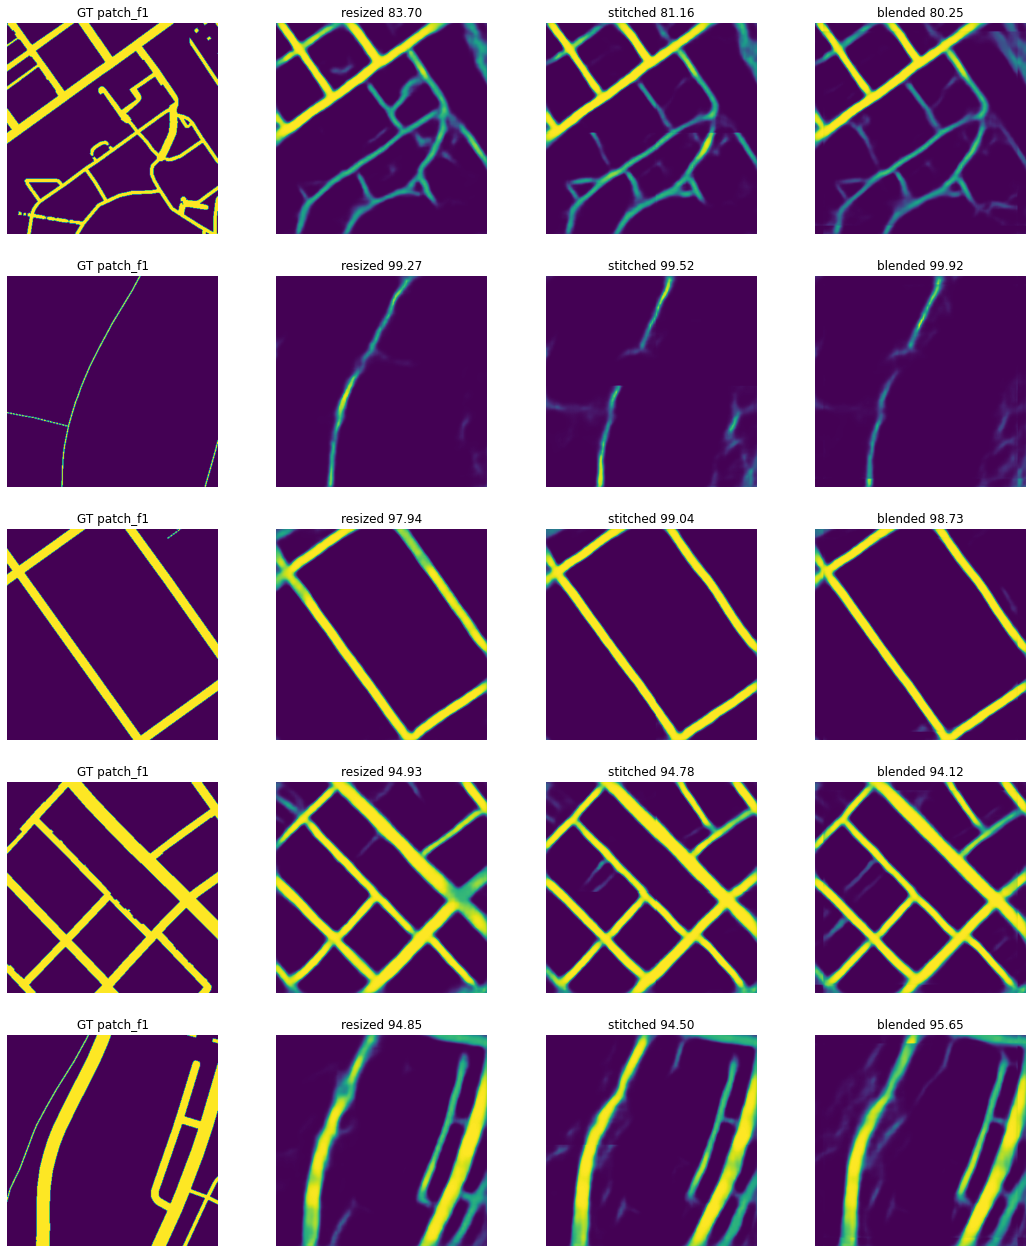

In [41]:
# Showing the best and worst results. resizing wins on average by a slight margin over blending
show_label_samples(masks, resized, stitched, blended, indices=[105,53,1,2,3]) # choose any valid index. here are those that performed best and worst from the model above plus some more

Now do the same for the test images. Here we can't get a score, but at least have a look at the differences and what looks best

In [4]:
test_image_fns = glob(os.path.join("training", "images", "*.png"))
test_images = np.stack([np.moveaxis(TF.to_tensor(Image.open(x).convert("RGB")).detach().numpy(),0,2) for x in test_image_fns],axis=0)

# Compute the predictions through the different methods
resized = predict_by_resizing(net,"test",resize_shape=(384,384))

part_predictions = predict_by_parts(net,"test")
stitched = stitch_predictions(part_predictions,16*12) # seam at center

blended = blend_predictions(part_predictions)

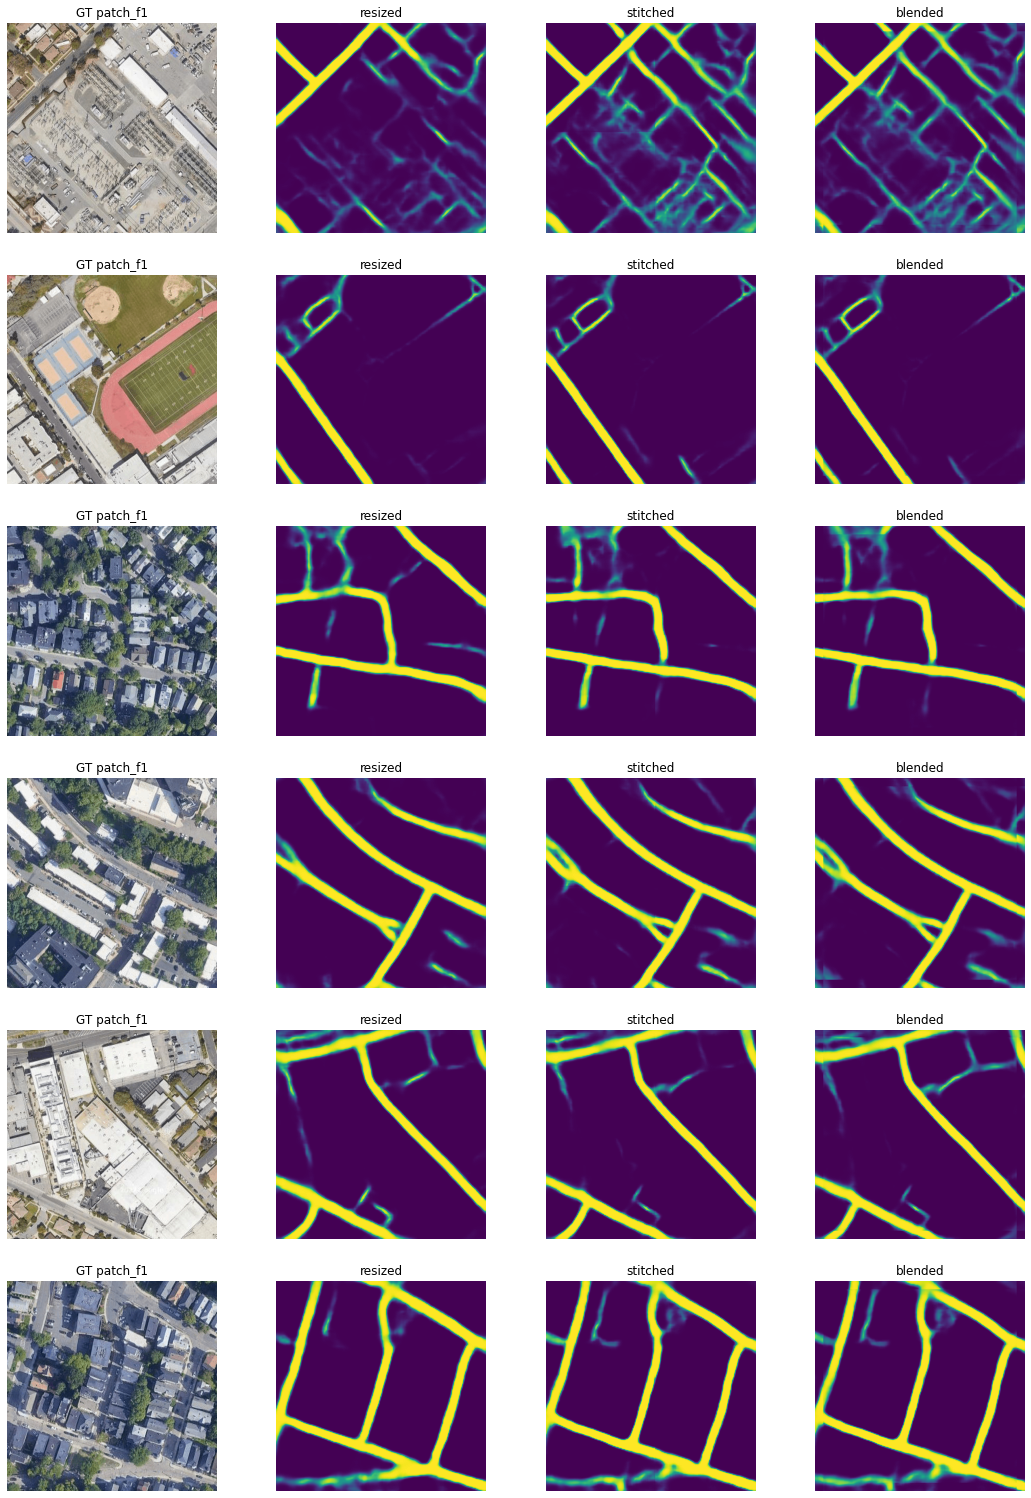

In [5]:
show_label_samples(test_images, resized, stitched, blended, indices=[0,1,2,3,4,5], no_score=True)